# Hyperopt

## About
- using Baysian optimization as default search method

## Requrirement
- install `hyperopt` package and `mongo` database
- using ml algorithm and utility function in `sklearn` package
- the example online is using `Python2`, we rewrite it with `Python3`

## Installation
Using `pip install --upgrade git+git://github.com/hyperopt/hyperopt.git` instead of `pip3 install hyperopt`.
<br>Or downgrade networkx package(`pip3 install networkx==1.11`)
<br>Since the [issue here](https://github.com/hyperopt/hyperopt/issues/325)

## Basic Usage
```python
best = fmin(
    #the function we want to minimize the return value
    fn= lambda x:x**2,
    
    #the search space we define about each hyperparameter
    space= hp.uniform('x', -10, 10),
    
    #the search method we specify, currently have less method than optunity
    algo= tpe.suggest,
    
    #the max evaluation number
    max_evals= 100,
    
    #the database in which to store all the point evaluations of the search
    trials = Trials()) 
```

## Search Spaces

- `hp.choice(label, options)` where options should be a python list or tuple.

- `hp.normal(label, mu, sigma)` where mu and sigma are the mean and standard deviation, respectively.

- `hp.uniform(label, low, high)` where low and high are the lower and upper bounds on the range.

- `hp.randint(label, upper)` where upper specifues a random integer in the range [0, upper). 
<br><br>
- when using `hp.choice`, result will show the index of the options list
- [Detailed search space description](https://github.com/hyperopt/hyperopt/wiki/FMin#21-parameter-expressions)

## Parallel Search with MongoDB

1. Start a mongodb database server process
2. Call `fmin` using `MongoTrials` instead of `Trials`
3. Launch some `hyperopt-mongo-worker` processes
4. wait for `fmin` to return
5. **all state is in DB** (can stop, restart `fmin`)

### experiment result
- I can run the example function in the GitHub wiki, but I can't run the code I write with the same method.
- We need do some tricks to run the code.

Reference
<br>[Parallelizing Evaluations During Search via MongoDB
](https://github.com/hyperopt/hyperopt/wiki/Parallelizing-Evaluations-During-Search-via-MongoDB)
<br>[Solve "AttributeError" when using hyperopt-mongo-worker](https://stackoverflow.com/questions/41373885/hyperopt-mongotrials-issue-with-pickle-attributeerror-module-object-has-no-a)

## Compare with `optunity`
- `optunity` have more search method than `hyperopt`
- `hyperopt` can have descrete choices as hyperparameter search space, `optunity` can't
- Both can read the data about hyperparameter and objective function value in each iteration
- `hyperopt` claim that it support parallel search, but it hard to use and have some problems

# Reference
- [Hyperopt GitHub wiki](https://github.com/hyperopt/hyperopt/wiki)
- [Parameter Tuning with Hyperopt](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce)
- [Hyperopt SciPy conference paper](http://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)

# Code DEMO

In [1]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
import matplotlib.pyplot as plt

### Import Iris dataset and necessary function

In [3]:
from sklearn import datasets
# the function used to do cross validation
# change `cv` parameter to specify fold-number, default is 3-fold
# parameter:(estimator, X(feature), y(label))
from sklearn.model_selection import cross_val_score
iris = datasets.load_iris()
X = iris.data
y = iris.target

## Using KNN and SVM to classify Iris dataset

### K-Nearest Neighbors(KNN)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
# define algorithm, using `cross_val_score` to return score
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

# define search space
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

# objective function
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

# create trial instance, which can store info during search
trials = Trials()

# run fmin to find the optimal hyperparameter
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print("best: ")
print(best)

best: 
{'n_neighbors': 4}


---
### *Trials* objects can store some info during search.
<br>`tid` is the time stamp(from `0` to `max_evals-1`)
<br>`loss` in `result` key is the objective function value with current objective value
<br>`vals` in `misc` key is the value of every hyperator`

In [5]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.8868464052287582, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'n_neighbors': [0]},
   'vals': {'n_neighbors': [49]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2018, 7, 23, 1, 43, 46, 522000),
  'refresh_time': datetime.datetime(2018, 7, 23, 1, 43, 46, 529000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.9734477124183006, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'n_neighbors': [1]},
   'vals': {'n_neighbors': [6]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2018, 7, 23, 1, 43, 46, 536000),
  'refresh_time': datetime.datetime(2018, 7, 23, 1, 43, 46, 541000)},
 {'state': 2,
  'tid': 2,
  'spec': None,
  'result': {'loss': -0.9734477124183006, 'status': 'ok'},


### show figure about the accuracy and neighbor value

Text(0,0.5,'cross validation accuracy')

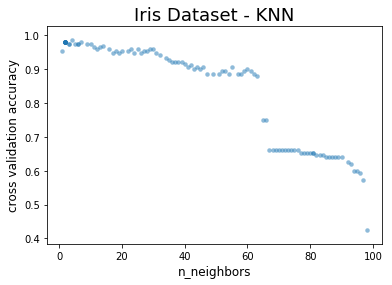

<Figure size 2160x2160 with 0 Axes>

In [6]:
f, ax = plt.subplots(1)
plt.figure(figsize=(30,30))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

### Show accuracy change in each iteration

Text(0,0.5,'cross validation accuracy')

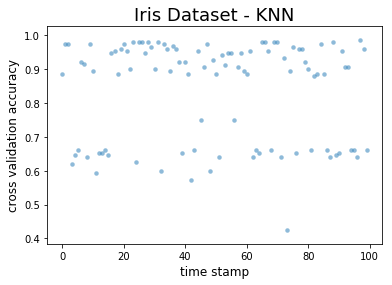

<Figure size 2160x2160 with 0 Axes>

In [7]:
f, ax = plt.subplots(1)
plt.figure(figsize=(30,30))
xs = [t['tid'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('time stamp', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

### Support Vector Macines(SVM)

In [8]:
# used to normalize and scale data
from sklearn.preprocessing import normalize, scale
from sklearn.svm import SVC

In [9]:
# package search algorithm
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()

# specify search space
space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

# objective function
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best)

best:
{'C': 1.7546745973934836, 'gamma': 11.898035848575926, 'kernel': 0, 'normalize': 0, 'scale': 0}


In [10]:
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [11]:
scope.define(GaussianNB)
scope.define(SVC)
scope.define(DecisionTreeClassifier)


sklearn.tree.tree.DecisionTreeClassifier

In [12]:
# define search space
C = hp.lognormal('C', 0, 1)

# using class "__name__" to call the class instance
space = hp.pchoice('estimator', [
    (0.1, scope.GaussianNB()),
    (0.2, scope.SVC(C=C, kernel='linear')),
    (0.3, scope.SVC(C=C, kernel='rbf',
        gamma=hp.lognormal('svm_rbf_width', 0, 1),)),
    (0.4, scope.DecisionTreeClassifier(
        criterion=hp.choice('dtree_criterion',
            ['gini', 'entropy']),
        max_depth=hp.choice('dtree_max_depth',
            [None, hp.qloguniform('dtree_max_depth_N',1, 5, 1)])))])

In [13]:
sample(space)

SVC(C=0.6908019421488653, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.19028060248465503,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
def f(params):
    return {'loss': -cross_val_score(params, X, y).mean(), 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best)

best:
{'C': 1.420892846317749, 'estimator': 1}
